In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from matplotlib.ticker import FormatStrFormatter
from sklearn.decomposition import KernelPCA

## Perceptron

In [16]:
class Perceptron(object):
    def __init__(self,eta = 0.01, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
    def fit(self,X,y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter): # The number of epochs
            errors = 0
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi)) # Calculate difference between actual vs predicted
                self.w_[1:] += update * xi # update the weight vector (except w0)
                self.w_[0] += update # Update w0
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    def net_input(self,X):
        return np.dot(X,self.w_[1:]) + self.w_[0] # Return the net input function
    def predict(self,X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        """np.where(condition, true_value, false_value) -> Return 1 if the activation function returns a value >1
                                                           Return -1  if the activation function returns a value <1"""

In [4]:
df = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header = None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1) # Versicolor = 1, Setosa = -1
X = df.iloc[0:100, [0, 2]].values

In [23]:
ppn = Perceptron()
ppn.fit(X, y)
sum(ppn.errors_)

10

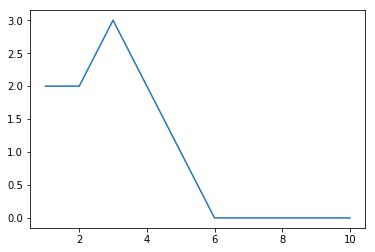

In [19]:
%matplotlib inline
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_)

## Adaline

In [24]:
class Adaline(object):
    def __init__(self,eta = 0.01, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
    def fit(self,X,y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter): # The number of epochs
            output = self.net_input(X) # Calculate the total net input function phi(z) = w_T.x
            errors = y - output # Calculate the error vector. Numpy array
            # Calculate weights based on gradient of input
            self.w_[1:] += self.eta * X.T.dot(errors) # update the weight vector (except w0). 
            # Dot product with input vector transposed and the error vector

            self.w_[0] += self.eta * errors.sum() # Update w0
            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        return self
    def net_input(self,X):
        return np.dot(X,self.w_[1:]) + self.w_[0] # Return the net input function
    def activation(self,X):
        return self.net_input(X)
    def predict(self,X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        """np.where(condition, true_value, false_value) -> Return 1 if the activation function returns a value >1
                                                           Return -1  if the activation function returns a value <1"""

In [33]:
ada = Adaline(eta = 0.0001)
ada.fit(X,y)
sum(ada.cost_)

445.10288778952537

## Adaline with Stochastic Gradient Descent

In [38]:
class AdalineSGD(object):
    def __init__(self,eta = 0.01, n_iter = 10, shuffle = True, random_state = None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.w_initialized = False
        if random_state:
            np.random.seed(random_state)
    def fit(self,X,y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter): # The number of epochs
            if self.shuffle:
                X,y = self._shuffle(X,y)
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi,target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    def partial_fit(self,X,y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X,y):
                self._update_weights(xi,target)
        else:
            self._update_weights(X,y)
        return self
    def _shuffle(self,X,y): # Returns a random sample of input and output
        r = np.random.permutation(len(y))
        return X[r],y[r]
    def _initialize_weights(self,m): # Initialize weights to a numpy array of zeros
        self.w_ = np.zeros(1+m)
        self.w_initialized = True
    def _update_weights(self,xi,target): # Calculate the 
        output = self.net_input(xi)
        error = target - output
        self.w_[1:] += self.eta + np.dot(xi,error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    def net_input(self,X):
        return np.dot(X,self.w_[1:]) + self.w_[0] # Return the net input function
    def activation(self,X):
        return self.net_input(X)
    def predict(self,X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        """np.where(condition, true_value, false_value) -> Return 1 if the activation function returns a value >1
                                                           Return -1  if the activation function returns a value <1"""

In [47]:
# Feature Scaling
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

In [51]:
ada_sgd = AdalineSGD(random_state = 1)
ada_sgd.fit(X_std,y)

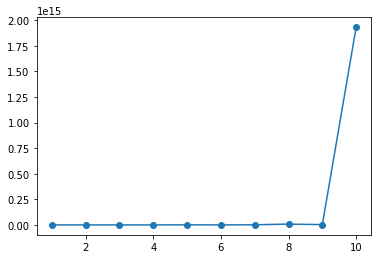

In [52]:
plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')

In [53]:
# Helper function
def plot_decision_regions(X, y, classifier,test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o', s=55, label='test set')

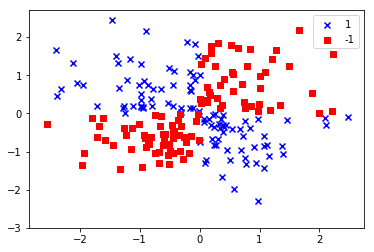

In [3]:
# np.random.seed(0)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1')
plt.ylim(-3.0)
plt.legend()
plt.show()

## Support Vector Machine with Kernel

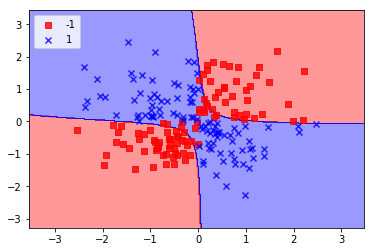

In [6]:
svm = SVC(kernel = 'rbf', gamma = 0.1, C = 10.0)
svm.fit(X_xor,y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

In [8]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
'Malic acid', 'Ash',
'Alcalinity of ash', 'Magnesium',
'Total phenols', 'Flavanoids',
'Nonflavanoid phenols',
'Proanthocyanins',
'Color intensity', 'Hue',
'OD280/OD315 of diluted wines',
'Proline']
print('Class labels', np.unique(df_wine['Class label']))
# Class labels [1 2 3]
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [10]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

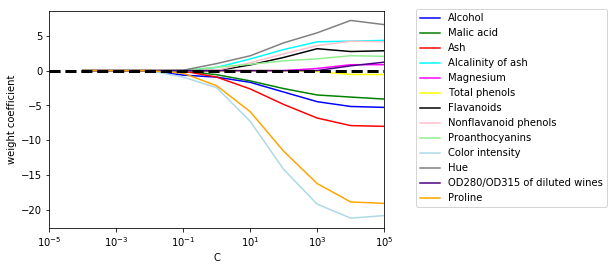

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
 'magenta', 'yellow', 'black',
 'pink', 'lightgreen', 'lightblue',
 'gray', 'indigo', 'orange']
weights, params = [], []
for c in range(-4, 6):
    # As we can see, all features weights will be zero if we penalize the model with a strong regularization parameter
    lr = LogisticRegression(penalty='l1', C=10**c,random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

In [29]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vecs)
print(eigen_vals)
print(np.linalg.norm(eigen_vecs[4]))

[[ 1.46698114e-01  5.04170789e-01 -1.17235150e-01  2.06254611e-01
  -1.87815947e-01 -1.48851318e-01 -1.79263662e-01 -5.54687162e-02
  -4.03054922e-01 -4.17197583e-01  2.75660860e-01  4.03567189e-01
   4.13320786e-04]
 [-2.42245536e-01  2.42168894e-01  1.49946576e-01  1.30489298e-01
   5.68639776e-01 -2.69052764e-01 -5.92636731e-01  3.32731614e-02
  -1.01833706e-01  2.17101488e-01 -8.13845005e-02 -1.52474999e-01
  -8.78560762e-02]
 [-2.99344215e-02  2.86984836e-01  6.56394387e-01  1.51536318e-02
  -2.99209426e-01 -9.33386061e-02  6.07334578e-02 -1.00618575e-01
   3.51841423e-01  1.28549846e-01 -1.29751275e-02  1.68376064e-01
  -4.52518598e-01]
 [-2.55190023e-01 -6.46871827e-02  5.84282337e-01 -9.04220851e-02
  -4.12499478e-02 -1.01342392e-01  2.50323869e-01  5.61658566e-02
  -5.00457282e-01  4.73344124e-02  9.89088030e-02 -6.70902926e-02
   4.86169765e-01]
 [ 1.20797723e-01  2.29953850e-01  8.22627466e-02 -8.39128346e-01
  -2.71971315e-02  1.12567350e-01 -2.85240559e-01  9.58423947e-02


In [44]:
eigen_pairs =[(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)
eigen_pairs

[(4.892308303273741,
  array([ 0.14669811, -0.24224554, -0.02993442, -0.25519002,  0.12079772,
          0.38934455,  0.42326486, -0.30634956,  0.30572219, -0.09869191,
          0.30032535,  0.36821154,  0.29259713])),
 (2.4663503157592306,
  array([ 0.50417079,  0.24216889,  0.28698484, -0.06468718,  0.22995385,
          0.09363991,  0.01088622,  0.01870216,  0.03040352,  0.54527081,
         -0.27924322, -0.174365  ,  0.36315461])),
 (1.4280997275048442,
  array([-0.11723515,  0.14994658,  0.65639439,  0.58428234,  0.08226275,
          0.18080442,  0.14295933,  0.17223475,  0.1583621 , -0.14242171,
          0.09323872,  0.19607741, -0.09731711])),
 (1.0123346209044954,
  array([ 0.20625461,  0.1304893 ,  0.01515363, -0.09042209, -0.83912835,
          0.19317948,  0.14045955,  0.33733262, -0.1147529 ,  0.07878571,
          0.02417403,  0.18402864,  0.05676778])),
 (0.8490645933450257,
  array([-0.18781595,  0.56863978, -0.29920943, -0.04124995, -0.02719713,
          0.14064543,

In [46]:
# numpy.hstack: Stack arrays in sequence horizontally (column wise).
# First 2 eigenvectors capture most of the variation. So construct projection matrix W with only those 2 eigenvectors
w= np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
w

array([[ 0.14669811,  0.50417079],
       [-0.24224554,  0.24216889],
       [-0.02993442,  0.28698484],
       [-0.25519002, -0.06468718],
       [ 0.12079772,  0.22995385],
       [ 0.38934455,  0.09363991],
       [ 0.42326486,  0.01088622],
       [-0.30634956,  0.01870216],
       [ 0.30572219,  0.03040352],
       [-0.09869191,  0.54527081],
       [ 0.30032535, -0.27924322],
       [ 0.36821154, -0.174365  ],
       [ 0.29259713,  0.36315461]])

In [48]:
# Convert the original 124 sample, 13 feature wine set into 124x2 set by dot product with projection matrix
X_train_pca = X_train_std.dot(w)
X_train_pca

array([[ 2.59891628,  0.00484089],
       [ 0.15819134, -2.26659577],
       [-2.6372337 ,  2.66488569],
       [-2.52848449,  0.51846618],
       [ 1.70922581, -0.91719459],
       [-2.83057003,  0.41936129],
       [-2.82251879,  1.99763147],
       [ 1.36618015,  0.04639099],
       [-2.46584868, -0.07932269],
       [-2.28554906, -0.40096658],
       [ 1.14246632, -2.39587633],
       [-2.28497881, -1.09274988],
       [-2.52924945,  0.6477328 ],
       [ 0.169245  , -1.1264982 ],
       [ 2.53088166,  1.05798498],
       [-0.71596964, -2.80365836],
       [ 2.46922033, -0.15871191],
       [-0.58044574, -0.69290749],
       [ 0.54583852,  0.41042188],
       [ 3.5604963 ,  1.42561284],
       [ 1.58679826, -1.51260121],
       [ 2.54872139, -0.05280515],
       [-3.59338727,  0.88321901],
       [-1.60406659,  2.40373662],
       [ 1.48668426, -1.40863724],
       [ 0.00830468, -2.04898307],
       [-0.15646658, -2.80278355],
       [-2.39863877,  2.47524175],
       [-3.13549157,

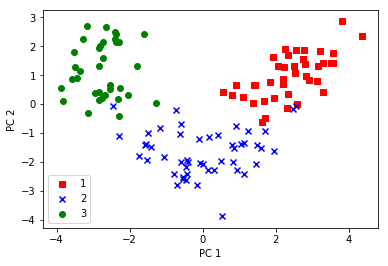

In [50]:
# x-axis : PCA 1
# y-axis : PCA 2
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

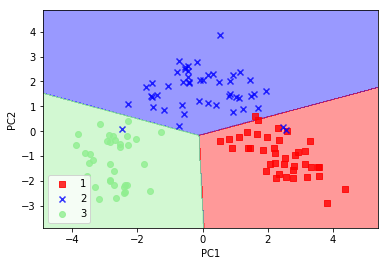

In [54]:
# The dataset becomes more linearly separable after PCA is applied
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

## PCA with RBF kernel

In [72]:
def rbf_kernel_pca(X, gamma, n_components):
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')
    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)
    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)
    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)
    # Collect the top k eigenvectors (projected samples)
    # np.column_stack: Take a sequence of 1-D arrays and stack them as columns to make a single 2-D array.
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    return X_pc

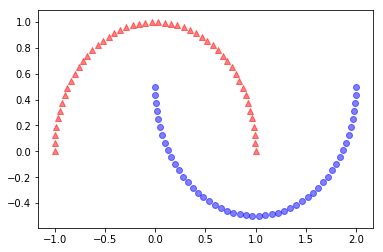

In [88]:
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

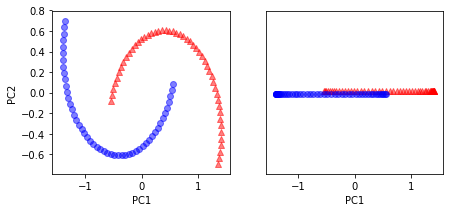

In [89]:
# Directly using PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

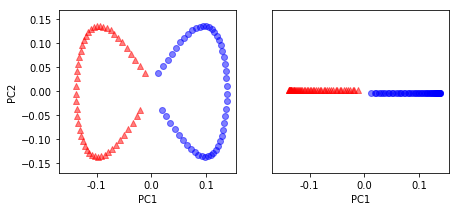

In [90]:
# Using custom rbf function
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02,color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

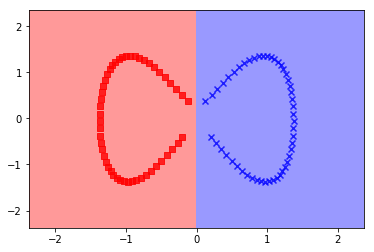

In [91]:
lr.fit(X_kpca,y)
X_kpca = stdsc.fit_transform(X_kpca)
plot_decision_regions(X_kpca, y, classifier=lr)

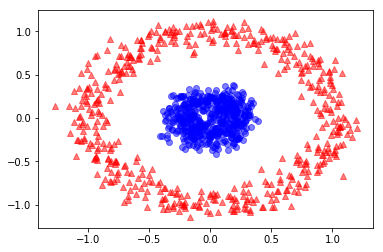

In [82]:
# Example 2
X, y = make_circles(n_samples=1000,
random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1],
color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
color='blue', marker='o', alpha=0.5)
plt.show()

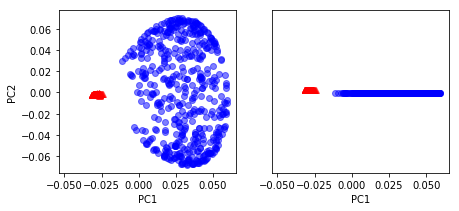

In [83]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

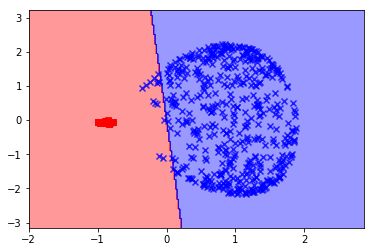

In [87]:
# We can see that the classes are now linearly separable!
lr.fit(X_kpca,y)
X_kpca = stdsc.fit_transform(X_kpca)
plot_decision_regions(X_kpca, y, classifier=lr)

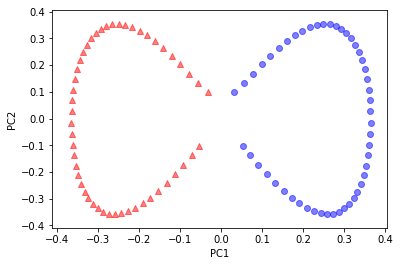

In [93]:
# Using sklearn inbuilt kernel pca
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2,
kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1],
color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()